**Fitting Thomson Scattering Spectra**:

 Thomson scattering diagnostics record a scattered power spectrum that encodes information about the electron and ion density, temperatures, and flow velocities. This information can be retrieved by fitting the measured spectrum with the theoretical spectral density (spectral_density). This notebook demonstrates how to use the lmfit package (along with some helpful PlasmaPy functions) to fit 1D Thomson scattering spectra.

In [ ]:
pip install plasmapy

In [2]:
import plasmapy

In [3]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import warnings

from lmfit import Parameters

from plasmapy.diagnostics import thomson

**Fitting Collective Thomson Scattering**

To demonstrate the fitting capabilities, we’ll first generate some synthetic Thomson data using the spectral_density function. This data will be in the collective regime, so we will generate two datasets (using the same plasma parameters and probe geometry) that correspond to the EPW and IAW features.

In [4]:
# Generate theoretical spectrum

In [5]:
probe_wavelength = 532 * u.nm

In [6]:
epw_wavelengths = (
    np.linspace(probe_wavelength.value - 30, probe_wavelength.value + 30, num=500)
    * u.nm
)

In [7]:
iaw_wavelengths = (
    np.linspace(probe_wavelength.value - 3, probe_wavelength.value + 3, num=500) * u.nm
)


In [8]:
probe_vec = np.array([1, 0, 0])
scattering_angle = np.deg2rad(63)
scatter_vec = np.array([np.cos(scattering_angle), np.sin(scattering_angle), 0])

n = 2e17 * u.cm**-3
ions = ["H+", "C-12 5+"]
T_e = 10 * u.eV
T_i = np.array([20, 50]) * u.eV
electron_vel = np.array([[0, 0, 0]]) * u.km / u.s
ion_vel = np.array([[0, 0, 0], [200, 0, 0]]) * u.km / u.s
ifract = [0.3, 0.7]

In [9]:
alpha, epw_skw = thomson.spectral_density(
    epw_wavelengths,
    probe_wavelength,
    n,
    T_e=T_e,
    T_i=T_i,
    ions=ions,
    ifract=ifract,
    electron_vel=electron_vel,
    ion_vel=ion_vel,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)

In [10]:
alpha, iaw_skw = thomson.spectral_density(
    iaw_wavelengths,
    probe_wavelength,
    n,
    T_e=T_e,
    T_i=T_i,
    ions=ions,
    ifract=ifract,
    electron_vel=electron_vel,
    ion_vel=ion_vel,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)

# PLOTTING

Note that these plots are showing the same spectral distribution, just over different wavelength ranges: the large peak in the center of the EPW spectrum is the IAW spectrum.

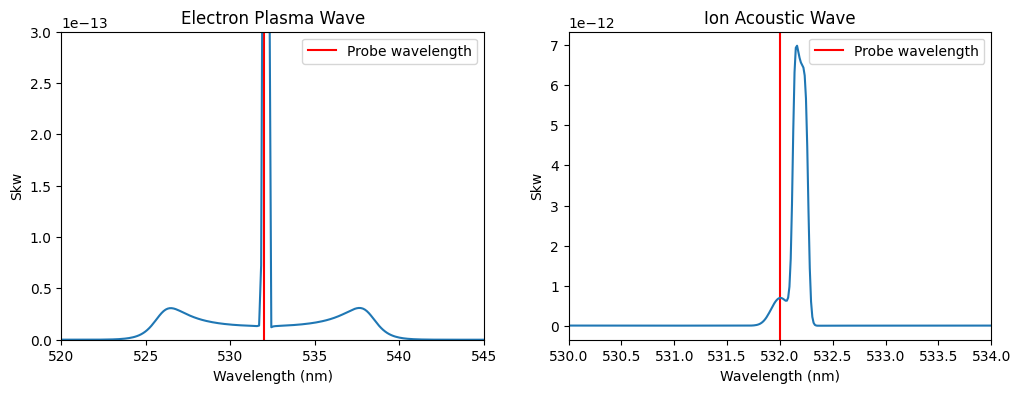

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax[0].set_xlim(520, 545)
ax[0].set_ylim(0, 3e-13)
ax[0].set_title("Electron Plasma Wave")
ax[0].plot(epw_wavelengths.value, epw_skw)
ax[0].legend()

ax[1].set_xlim(530, 534)
ax[1].set_title("Ion Acoustic Wave")
ax[1].plot(iaw_wavelengths.value, iaw_skw)
ax[1].legend();

Next we’ll add some noise to the spectra to simulate an experimental measurement.

In [12]:
epw_skw *= 1 + np.random.normal(loc=0, scale=0.1, size=epw_wavelengths.size)

In [13]:
iaw_skw *= 1 + np.random.normal(loc=0, scale=0.1, size=iaw_wavelengths.size)

The more of the EPW spectrum we exclude, the less sensitive the fit will become. So, we want to block as little as possible while still obscuring the IAW feature.

In [14]:
notch_range = (531, 533)
x0 = np.argmin(np.abs(epw_wavelengths.value - notch_range[0]))
x1 = np.argmin(np.abs(epw_wavelengths.value - notch_range[1]))
epw_skw[x0:x1] = np.nan

Another option is to delete the missing data from both the data vector and the corresponding wavelengths vector.

In [15]:
epw_skw = np.delete(epw_skw, slice(x0,x1,None))
epw_wavelengths = np.delete(epw_wavelengths, slice(x0,x1,None))

Finally, we need to get rid of the units and normalize the data on each detector to its maximum value (this is a requirement of the fitting algorithm). We’re using np.nanmax() here to ignore the NaN values in epw_skw.

In [16]:
epw_skw = epw_skw.value
epw_skw *= 1 / np.nanmax(epw_skw)
iaw_skw = iaw_skw.value
iaw_skw *= 1 / np.nanmax(iaw_skw)

# Plot again

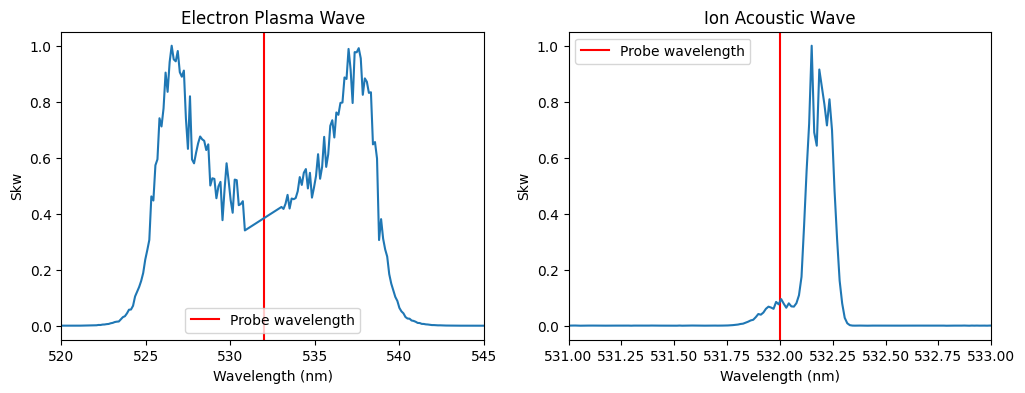

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax[0].set_xlim(520, 545)
ax[0].set_title("Electron Plasma Wave")
ax[0].plot(epw_wavelengths.value, epw_skw)
ax[0].legend()

ax[1].set_xlim(531, 533)
ax[1].set_title("Ion Acoustic Wave")
ax[1].plot(iaw_wavelengths.value, iaw_skw)
ax[1].legend();

**Fitting the EPW Feature**

In order to fit this data in lmfit we need to create an lmfit.Model object for this problem. PlasmaPy includes such a model function for fitting Thomson scattering spectra, spectral_density_model. This model function is initialized by providing the parameters of the fit in the form of an lmfit.Parameters object.

In [ ]:
help(thomson.spectral_density_model)

We will now create the lmfit.Parameters object and settings dictionary using the values defined earlier when creating the sample data. We will choose to vary both the density and electron temperature, and will intentionally set incorrect initial values for both parameters. Note that, even though only one electron population is included, we must still name the temperature variable Te_0 in accordance with the convention defined above.

In [21]:
params = Parameters()
params.add(
    "n", value=4e17 * 1e6, vary=True, min=5e16 * 1e6, max=1e18 * 1e6
)

In [22]:
# Converting cm^-3 to m^-3
params.add("T_e_0", value=5, vary=True, min=0.5, max=25)
params.add("T_i_0", value=5, vary=False)
params.add("T_i_1", value=10, vary=False)
params.add("ifract_0", value=0.8, vary=False)
params.add("ifract_1", value=0.2, vary=False)
params.add("ion_speed_0", value=0, vary=False)
params.add("ion_speed_1", value=0, vary=False)

In [23]:
settings = {}
settings["probe_wavelength"] = probe_wavelength.to(u.m).value
settings["probe_vec"] = probe_vec
settings["scatter_vec"] = scatter_vec
settings["ions"] = ions
settings["ion_vdir"] = np.array([[1, 0, 0], [1, 0, 0]])

We can now use these objects to initialize an lmfit.Model object based on the spectral_density function using the spectral_density_model function.

In [24]:
epw_model = thomson.spectral_density_model(
    epw_wavelengths.to(u.m).value, settings, params
)

In addition, of course we also need to include the data to be fit (epw_skw), the independent variable (wavelengths) and the parameter object. It is important to note that the data to be fit should be a np.ndarray (unit-less) and normalized.

In [25]:
fit_kws = {}
epw_result = epw_model.fit(
    epw_skw,
    params=params,
    wavelengths=epw_wavelengths.to(u.m).value,
    method="differential_evolution",
    fit_kws=fit_kws,
)

The return from this function is a lmfit.ModelResult object, which is a convenient container holding lots of information! To start with, we can see the best-fit parameters, number of iterations, the chiSquared goodness-of-fit metric, and plot the best-fit curve.

In [26]:
# Print some of the results compared to the true values
answers = {"n": 2e17, "T_e_0": 10}
for key, ans in answers.items():
    print(f"{key}: {epw_result.best_values[key]:.1e} (true value {ans:.1e})")

print(f"Number of fit iterations:{epw_result.nfev}")
print(f"Reduced Chisquared:{epw_result.redchi:.4f}")

# Extract the best fit curve by evaluating the model at the final parameters
n_fit = epw_result.values["n"]
Te_0_fit = epw_result.values["T_e_0"]

n: 2.0e+23 (true value 2.0e+17)
T_e_0: 9.9e+00 (true value 1.0e+01)
Number of fit iterations:555
Reduced Chisquared:0.0008


Note that the best_fit curve skips the NaN values in the data, so the array is shorter than epw_skw. In order to plot them against the same wavelengths, we need to create an array of indices where epw_skw is not NaN.

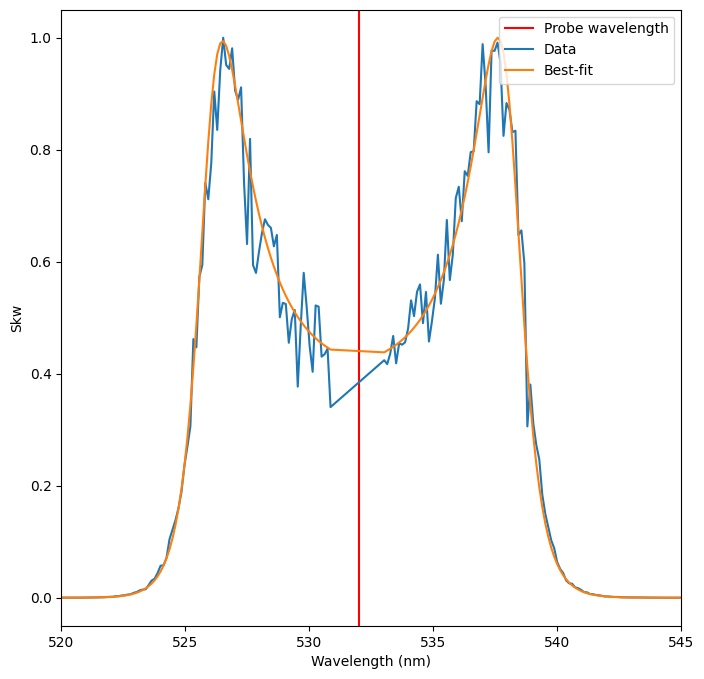

In [27]:
# Extract the best fit curve
best_fit_skw = epw_result.best_fit

# Get all the non-nan indices (the best_fit_skw just omits these values)
not_nan = np.argwhere(np.logical_not(np.isnan(epw_skw)))

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax.set_xlim(520, 545)

ax.plot(epw_wavelengths.value, epw_skw, label="Data")
ax.plot(epw_wavelengths.value[not_nan], best_fit_skw, label="Best-fit")
ax.legend(loc="upper right");

The resulting fit is very good, even though many of the ion parameters are still pretty far from their actual values!

**Fitting the IAW Feature**
We will now follow the same steps to fit the IAW feature. We’ll start by setting up a new lmfit.Parameters object, this time using the best-fit values from the EPW fit as fixed values for those parameters.

In [28]:
settings = {}
settings["probe_wavelength"] = probe_wavelength.to(u.m).value
settings["probe_vec"] = probe_vec
settings["scatter_vec"] = scatter_vec
settings["ions"] = ions
settings["ion_vdir"] = np.array([[1, 0, 0], [1, 0, 0]])

params = Parameters()
params.add("n", value=n_fit, vary=False)
params.add("T_e_0", value=Te_0_fit, vary=False)
params.add("T_i_0", value=10, vary=True, min=5, max=60)
params.add("T_i_1", value=10, vary=True, min=5, max=60)
params.add("ifract_0", value=0.5, vary=True, min=0.2, max=0.8)
params.add("ifract_1", value=0.5, vary=True, min=0.2, max=0.8, expr="1.0 - ifract_0")
params.add("ion_speed_0", value=0, vary=False)
params.add("ion_speed_1", value=0, vary=True, min=0, max=1e6)

Now we will run the fit

In [29]:
iaw_model = thomson.spectral_density_model(
    iaw_wavelengths.to(u.m).value, settings, params
)

iaw_result = iaw_model.fit(
    iaw_skw,
    params=params,
    wavelengths=iaw_wavelengths.to(u.m).value,
    method="differential_evolution",
)

In [30]:
# Print some of the results compared to the true values
answers = {
    "T_i_0": 20,
    "T_i_1": 50,
    "ifract_0": 0.3,
    "ifract_1": 0.7,
    "ion_speed_1": 2e5,
}
for key, ans in answers.items():
    print(f"{key}: {iaw_result.best_values[key]:.1f} (true value {ans:.1f})")

print(f"Number of fit iterations:{iaw_result.nfev:.1f}")
print(f"Reduced Chisquared:{iaw_result.redchi:.4f}")

T_i_0: 37.0 (true value 20.0)
T_i_1: 32.8 (true value 50.0)
ifract_0: 0.3 (true value 0.3)
ifract_1: 0.7 (true value 0.7)
ion_speed_1: 199852.7 (true value 200000.0)
Number of fit iterations:1480.0
Reduced Chisquared:0.0005


And plot the results

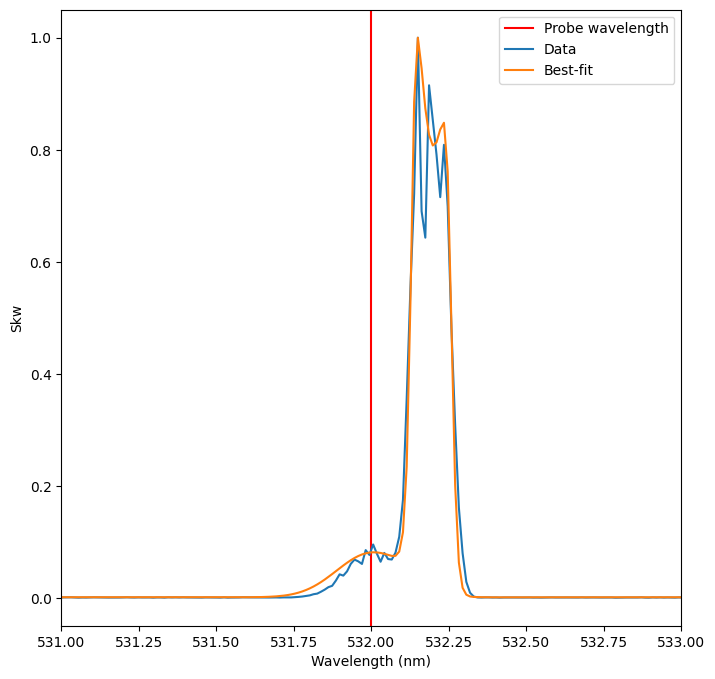

In [31]:
# Extract the best fit curve
best_fit_skw = iaw_result.best_fit

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax.set_xlim(531, 533)

ax.plot(iaw_wavelengths.value, iaw_skw, label="Data")
ax.plot(iaw_wavelengths.value, best_fit_skw, label="Best-fit")
ax.legend(loc="upper right");

**Fitting Non-Collective Thomson Scattering**


The non-collective Thomson scattering spectrum depends only on the electron density and temperature. In this regime the spectrum is less featured and, consequently, fits will produce larger errors. Otherwise, the fitting procedure is the same.

To illustrate fitting in this regime, we’ll start by generating some test data

In [32]:
nc_wavelengths = (
    np.linspace(probe_wavelength.value - 50, probe_wavelength.value + 50, num=1000)
    * u.nm
)

In [33]:
n = 5e15 * u.cm**-3
T_e = 5 * u.eV
T_i = np.array([1]) * u.eV
ions = ["H+"]

In [34]:
alpha, Skw = thomson.spectral_density(
    nc_wavelengths,
    probe_wavelength,
    n,
    T_e=T_e,
    T_i=T_i,
    ions=ions,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)

In [35]:
# Normalize and add noise
nc_skw = Skw.value
nc_skw *= 1 / np.nanmax(nc_skw)
nc_theory = np.copy(nc_skw)
nc_skw *= 1 + np.random.normal(loc=0, scale=0.1, size=nc_wavelengths.size)

# Plot again

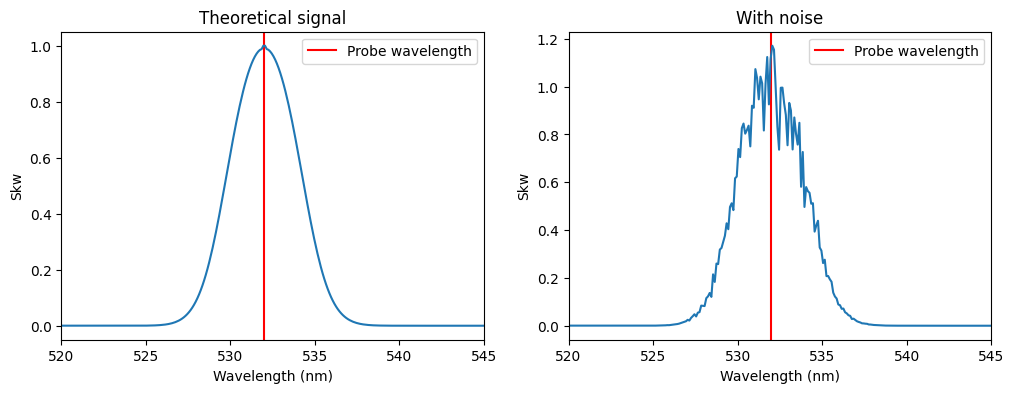

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax[0].set_xlim(520, 545)
ax[0].set_title("Theoretical signal")
ax[0].plot(nc_wavelengths.value, nc_theory)
ax[0].legend()

ax[1].set_xlim(520, 545)
ax[1].set_title("With noise")
ax[1].plot(nc_wavelengths.value, nc_skw)
ax[1].legend();

we still need to provide a value for n because it is a required argument for spectral_density, but this parameter should be fixed and its value can be a rough approximation.

In [37]:
settings = {}
settings["probe_wavelength"] = probe_wavelength.to(u.m).value
settings["probe_vec"] = probe_vec
settings["scatter_vec"] = scatter_vec
settings["ions"] = ions

params = Parameters()
params.add("n", value=1e15 * 1e6, vary=False)  # Converting cm^-3 to m^-3
params.add("T_e_0", value=1, vary=True, min=0.1, max=20)
params.add("T_i_0", value=1, vary=False)

nc_model = thomson.spectral_density_model(
    nc_wavelengths.to(u.m).value, settings, params
)

nc_result = nc_model.fit(
    nc_skw,
    params,
    wavelengths=nc_wavelengths.to(u.m).value,
    method="differential_evolution",
)

T_e_0: 6.1 (true value 5)
Number of fit iterations:128
Reduced Chisquared:0.0005


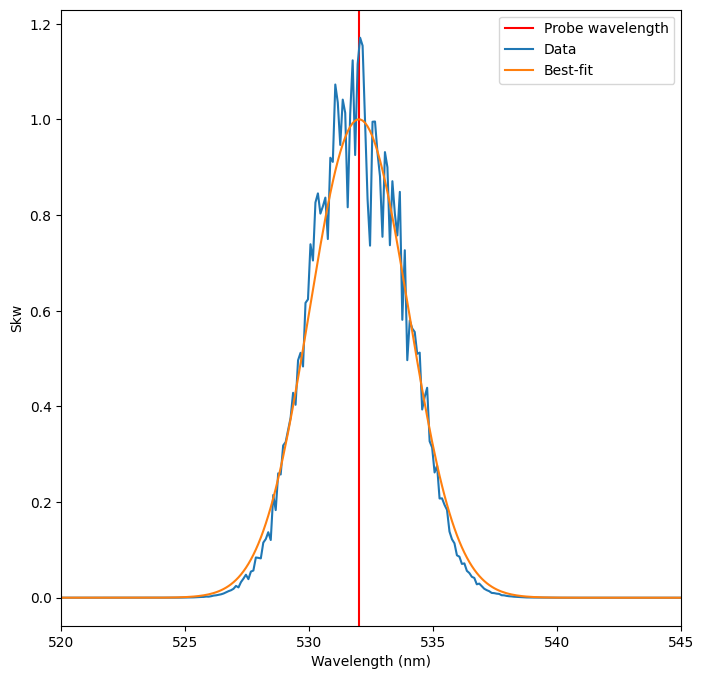

In [38]:
best_fit_skw = nc_result.best_fit

print(f"T_e_0: {nc_result.best_values['T_e_0']:.1f} (true value 5)")
print(f"Number of fit iterations:{nc_result.nfev}")
print(f"Reduced Chisquared:{nc_result.redchi:.4f}")

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax.set_xlim(520, 545)

ax.plot(nc_wavelengths.value, nc_skw, label="Data")
ax.plot(nc_wavelengths.value, best_fit_skw, label="Best-fit")
ax.legend(loc="upper right");